In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from statsmodels.stats.weightstats import DescrStatsW

# Change default colours to personal colour scheme
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["indianred", "cornflowerblue", "mediumseagreen", "plum", "sandybrown"]) 

In [4]:
rootPath = r"/home/daraghhollman/main/UCD_PASS_Labs/ComptonScattering"

In [5]:
def LoadFile(path):
    data = np.array(np.loadtxt(path, skiprows=1))
    return data

def DegToRad(deg):
    rad = deg * np.pi / 180
    return rad

def RadToDeg(rad):
    deg = rad / np.pi * 180
    return deg

def LinearFunction(x, m, c):
    return m*x + c

In [6]:
def InverseGammaEnergyTheory(x):
    return 1.51 + 1.956 * (x)

In [7]:
partOneData = LoadFile(rootPath + r"/LabWork/Data/dataPart1.txt")
angleError = DegToRad(2)

In [8]:
def EnergyAnglePlot(path):
    data = LoadFile(path)

    anglesDeg = data[:,2]
    anglesRad = [DegToRad(el) for el in anglesDeg]

    energies = data[:,3] # note energies in keV
    energiesError = [el/2 for el in data[:,4]]

    anglesToPlot = [1-np.cos(el) for el in anglesRad]
    energiesToPlot = [1/el for el in energies]
    energiesErrorToPlot = [el/energy**2 for el, energy in zip(energiesError, energies)]
    
    # Experiment
    pars, cov = curve_fit(LinearFunction, anglesToPlot, energiesToPlot)
    xRange = np.arange(np.min(anglesToPlot), np.max(anglesToPlot) + 0.01, 0.01)

    plt.errorbar(anglesToPlot, energiesToPlot, xerr=np.sqrt(np.sin(anglesToPlot)**2 * angleError**2), yerr=energiesErrorToPlot, label="Data", fmt="o", capsize=3, linewidth=1)

    plt.plot(xRange, LinearFunction(xRange, pars[0], pars[1]), label="Linear Fit")

    plt.plot(anglesToPlot, [InverseGammaEnergyTheory(el)/1000 for el in anglesToPlot], label="Theory")

    plt.grid()
    plt.legend()
    plt.xlabel("1-cos($\phi$)")
    plt.ylabel("$1/E_\gamma$ keV$^{-1}$")

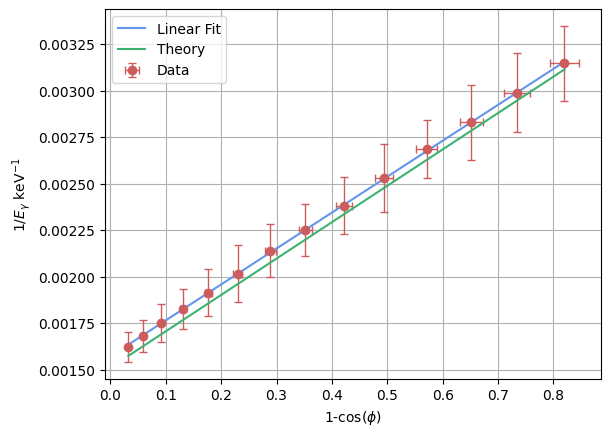

In [9]:
EnergyAnglePlot(path = rootPath + r"/LabWork/Data/dataPart1.txt")
# Note to dobule check units

In [10]:
def TheoreticalCrossSection(angle, electronRadius, alpha, solidAngle):
    # The Klein-Nishina formula
    A = (electronRadius**2 / 2) * (1 + np.cos(angle)**2) / (1 + alpha * (1 - np.cos(angle)))**2
    B = 1 + (alpha**2 * (1 - np.cos(angle))**2) / ((1 + np.cos(angle)**2) * (1 + alpha * (1 - np.cos(angle))))

    return A * B

In [11]:
def MeasuredCrossSection(sumUnderPhotopeak, countingTime, peakEfficiency, massOfRod, atomicNumber, atomicMass, solidAngle, intensity):
    
    avogadrosNumber = 6.0221408e23

    numberOfElectronsInSample = massOfRod * atomicNumber * avogadrosNumber / atomicMass
    
    A = sumUnderPhotopeak / countingTime / peakEfficiency
    B = numberOfElectronsInSample * solidAngle * intensity

    return A / B

In [12]:
def SolidAngle(detectorArea, distance):
    return detectorArea / distance**2

def IntrinsicPeakEfficiency(energyMeV):
    return 0.1522 * (energyMeV*10**-3)**-1.1325

In [13]:
solidAngle = SolidAngle(np.pi, 26) # cm

In [14]:
def CrossSectionPlot(path, scaleConstant):
    data = LoadFile(path)

    electronRadius = 2.82 * 10**-13 # cm
    alpha = 1.29 # For Cs137, Photopeak energy / electron rest mass

    intensty = 1.013 * 10**6 * np.exp(-45.59 / 43.48)

    # Theory
    angleRangeRad = np.arange(0, np.pi / 2, 0.01)
    angleRangeDeg = [RadToDeg(el) for el in angleRangeRad]

    anglesDeg = data[:,2]

    energies = data[:,3]
    energiesError = [el/2 for el in data[:,4]]

    netCounts = data[:,5]
    netCountsUncertainty = data[:,6]

    liveTime = data[:,7]

    errors = []
    i = 0
    for el in netCountsUncertainty:
        
        A = el**2*MeasuredCrossSection(1, liveTime[i], IntrinsicPeakEfficiency(energies[i]), 79.3, 13, 26.98, solidAngle, intensty)**2
        B = (energiesError[i]/2)**2 * (-0.1724*(energies[i]*10**-3)**-2.1325 * 10**-3)**2 *\
              (-netCounts[i] / ((79.3 * 13 * 6.022e23 / 26.98) * solidAngle * IntrinsicPeakEfficiency(energies[i])**2 * liveTime[i] * intensty))**2
        
        errors.append(scaleConstant * np.sqrt(A + B))
        
        i+=1


    plt.errorbar(anglesDeg, scaleConstant * MeasuredCrossSection(netCounts, liveTime, IntrinsicPeakEfficiency(energies), 79.3, 13, 26.98, solidAngle, intensty),\
             fmt="o", label="Data", xerr=RadToDeg(angleError), yerr=errors, linewidth=1, capsize=3)
    
    plt.plot(angleRangeDeg, TheoreticalCrossSection(angleRangeRad, electronRadius, alpha, solidAngle), label="Theory: Klein-Nishina")
    
    plt.grid()
    plt.xlabel("Scattering Angle (Degrees)")
    plt.ylabel("Differential Cross Section (cm$^2$/sr)")
    plt.legend()

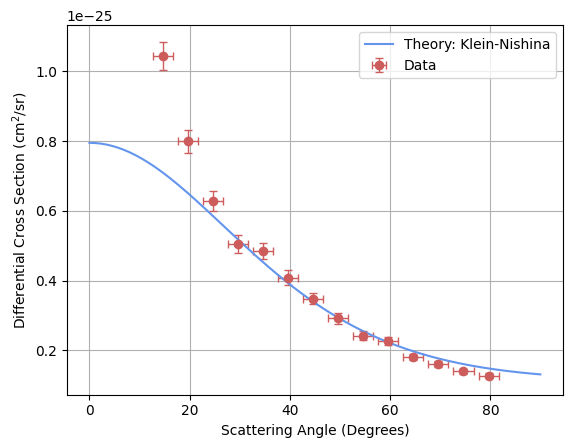

In [15]:
CrossSectionPlot(rootPath + r"/LabWork/Data/dataPart1.txt", 4.95)

# Part 2

In [16]:
partTwoData = LoadFile(rootPath + r"/LabWork/Data/dataPart2.txt")

In [17]:
def ClassicalRestMass(gammaEnergy, kineticEnergy):
    return 0.5 * (2*gammaEnergy - kineticEnergy)**2 / kineticEnergy

def RelativisticRestMass(gammaEnergy, kineticEnergy):
    return 2 * gammaEnergy * (gammaEnergy - kineticEnergy) / kineticEnergy

In [18]:
def UnpackComptonRealtivisticData(path):
    data = LoadFile(path)

    photopeaks = data[:,0]
    comptonEdges = data[:,1]
    uncertainty = data[:,2]

    return [photopeaks, comptonEdges, uncertainty]

In [19]:
def ClassicalRestEnergyPlot(path):

    photopeaks, comptonEdges, uncertainties = UnpackComptonRealtivisticData(path)

    restMasses = [ClassicalRestMass(photopeak, comptonEdge) for photopeak, comptonEdge in zip(photopeaks, comptonEdges)]

    pars, cov = curve_fit(LinearFunction, comptonEdges, restMasses)

    yError = [np.sqrt(((T**2 - 4 * E**2) / (2 * T**2))**2 * u**2) for E, T, u in zip(photopeaks, comptonEdges, uncertainties)]

    plt.errorbar(comptonEdges, restMasses, yerr=yError, zorder=2, label="Data", fmt="o", linewidth=1, capsize=3)

    plt.plot(comptonEdges, LinearFunction(comptonEdges, pars[0], pars[1]), color="cornflowerblue", zorder=1, label="Linear Fit")

    plt.grid()
    plt.xlabel("T (keV)")
    plt.ylabel("$m_{nr} c^2$ (keV)")
    plt.legend()

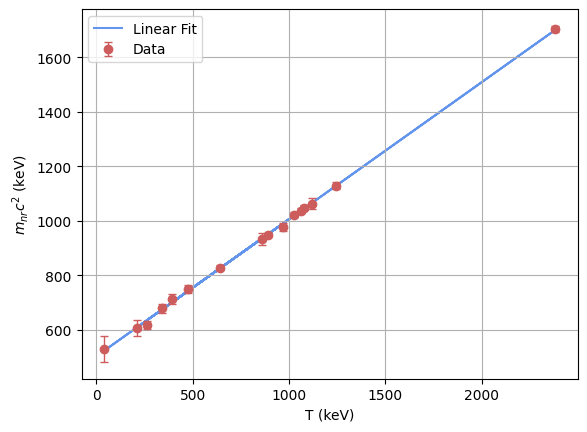

In [20]:
ClassicalRestEnergyPlot(rootPath + r"/LabWork/Data/dataPart2.txt")

In [21]:
def RelativisticRestEnergyPlot(path):
    
    plt.figure(figsize=(12,3))

    photopeaks, comptonEdges, uncertainty = UnpackComptonRealtivisticData(path)

    restMasses = [RelativisticRestMass(photopeak, comptonEdge) for photopeak, comptonEdge in zip(photopeaks, comptonEdges)]

    yError = [np.sqrt((2 * E**2 / T**2)**2 * u**2) for E, T, u in zip(photopeaks, comptonEdges, uncertainty)]

    plt.errorbar(comptonEdges, restMasses, xerr=uncertainty, yerr=yError, fmt="o", linewidth=1, capsize=3, zorder=2, label="Data")

    stats = DescrStatsW(restMasses, weights=[error/np.min(yError) for error in yError], ddof=0)

    mean = stats.mean
    std = stats.std

    plt.hlines(mean, 0, 2500, color="cornflowerblue", linestyles="-", label=f"Mean: {mean:.1f} keV")
    plt.hlines(mean+std, 0, 2500, color="grey", linestyles="--", label=f"Standard Deviation: {std:.1f} keV")
    plt.hlines(mean-std, 0, 2500, color="grey", linestyles="--")

    plt.xlabel("T (keV)")
    plt.ylabel("$m_{nr} c^2$ (keV)")
    plt.legend()
    plt.xticks(np.arange(0, 2501, 500))
    plt.xticks(np.arange(0, 2501, 50), minor=True)
    plt.margins(x=0, y=0.15)
    plt.grid()

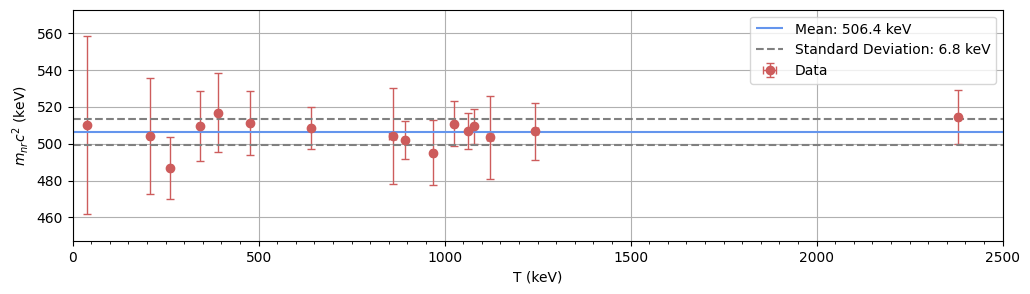

In [22]:
RelativisticRestEnergyPlot(rootPath + r"/LabWork/Data/dataPart2.txt")

In [78]:
"""
def Gamma(E, T):
    return 1 + T**2 / (2 * E * (E - T))

def GammaError(E, T, uE, uT):
    
    dgdT = (4*E*T*(E-T) + 2*T**2 * E) / (2*E*(E-T))**2
    dgdE = - (2*T**2 / (2*E*(E-T))**2) * 2*(E-T)

    return np.sqrt(dgdT**2 * uT**2 + dgdE**2 * uE**2)
"""
def Gamma(T):
    return T / 506.4

def Beta(E, T):
    return (T * (2*E - T)) / (T**2 - 2*E*T + 2*E**2)

def BetaError(E, T, uE, uT):

    dBdT = (-4*E**2 * T + 4*E**3) / (T**2 - 2*E*T + 2*E**2)**2
    dBdE = T * (-4*E**2 + 4*T*E) / (T**2 - 2*T*E + 2*E**2)**2

    return np.sqrt(dBdT**2 * uT**2 + dBdE**2 * uE**2)

def TheoreticalGamma(beta):
    return 1 / np.sqrt(1 - beta**2)

def GammaFit(beta, a, b):
    return 1 / np.sqrt(a + b*beta**2)

In [81]:
def GammaAgainstBeta(path):
    
    photopeaks, comptonEdges, uncertainty = UnpackComptonRealtivisticData(path)

    gammaError = []
    betaError = []
    for E, T, uE, uT in zip (photopeaks, comptonEdges, uncertainty, uncertainty):
        #gammaError.append(GammaError(E, T, uE, uT))
        betaError.append(BetaError(E, T, uE, uT))

    plt.errorbar(Beta(photopeaks, comptonEdges), Gamma(comptonEdges), xerr=betaError,\
                  fmt="o", linewidth=1, capsize=3, label="Data")

    betaRange = np.arange(0, 1, 0.01)
    pars, cov = curve_fit(GammaFit, Beta(photopeaks, comptonEdges), Gamma(comptonEdges))

    #plt.plot(betaRange, TheoreticalGamma(betaRange), linestyle="dotted", label="Theory")
    plt.plot(betaRange, GammaFit(betaRange, pars[0], pars[1]), linestyle = "dashed", label=f"Fit Function a={pars[0]}, b={pars[1]}")

    plt.xlabel(r"$\beta$")
    plt.ylabel("$\gamma$")
    plt.legend()
    plt.grid()

/tmp/ipykernel_10253/175230212.py:29: RuntimeWarning: invalid value encountered in sqrt
  return 1 / np.sqrt(a + b*beta**2)


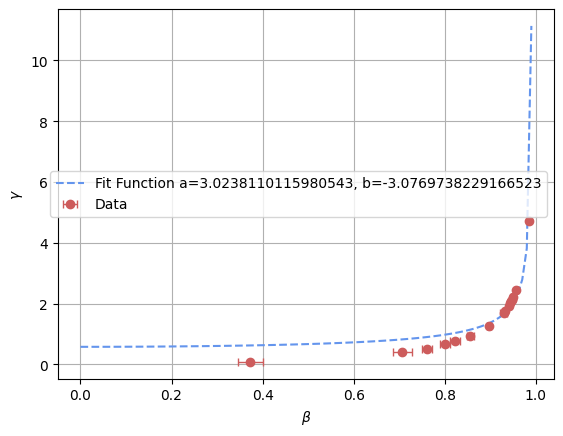

In [82]:
GammaAgainstBeta(rootPath + r"/LabWork/Data/dataPart2.txt")